## Exploratory Data Analysis (EDA) of BTC/ETH prices and GoogleNews search frequency of the word "cryptocurrency"

Due to volatility of crytocurrency market, one might wonder what is the best way to predict the currencies prices. As I came up with the project idea, the preliminary questions I had in mind were:

1. Is there any obvious correlation/lead-lag relationship between different crytocurrency market prices?
2. If the correlation between a pair of currencies A and B existed, can we use currency A price history to predict future price of currency B? Will it be more useful than using just historical prices of currency B alone?
3. Does the rise/fall in search frequency of the word "crytocurrency" on GoogleNews imply trading signal?

The following code queries, visualizes, and tests data in order to explore the preliminary questions. The stretch goal is to gain insights beyond preliminary questions that will lead to better data analysis in the future



In [1]:
# Getting price data of BTC and ETH using Cryptocompare API

import requests
import json
import pandas as pd
from pandas.io.json import json_normalize
import datetime

# Indicate how many rows of data here
lim = '15000' 
story_coin = ['BTC', 'ETH']
story_data = pd.DataFrame()
for i in story_coin:
    URL = 'https://min-api.cryptocompare.com/data/histohour?fsym='+i+'&tsym=USD&limit='+lim
    data = requests.get(URL)
    json_data = data.json()
    table = json_normalize(json_data, 'Data').set_index('time')
    table.index = pd.to_datetime(table.index ,unit='s')
    story_data = pd.concat([story_data, table.high], axis=1)
story_data.columns = story_coin

In [2]:
# Getting data from Google Trends using Pytrends API

from pytrends.request import TrendReq
# Login to Google. Only need to run this once
pytrend = TrendReq()
# Create payload and capture API tokens. Only needed for interest_over_time(), interest_by_region() & related_queries()
# keyword = 'cryptocurrency', cathegory = 16 (news), timeframe- limit range to 8 months to get daily data
pytrend.build_payload(kw_list=['cryptocurrency'], cat=16, timeframe='2017-02-24 2017-10-24')  

story_ggtrends = pytrend.interest_over_time()
# Upsampling daily data to hourly data
story_ggtrends = story_ggtrends.resample('1h').pad().drop(['isPartial'], axis='columns')
story_ggtrends.columns = ['SearchFrequency']

In [3]:
# Joining two data frames
story_combined = pd.concat([story_data, story_ggtrends], axis=1).dropna(how='any')
story_combined_scaled = story_combined.copy(deep=True)

In [4]:
# Feature Scaling. This will capture trend information and makes visualization more meaningful
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
story_combined_scaled['BTC'] = sc_x.fit_transform(story_combined_scaled['BTC'].values.reshape(-1,1))
story_combined_scaled['ETH'] = sc_x.fit_transform(story_combined_scaled['ETH'].values.reshape(-1,1))
story_combined_scaled['SearchFrequency'] = sc_x.fit_transform(story_combined_scaled['SearchFrequency'].values.reshape(-1,1))


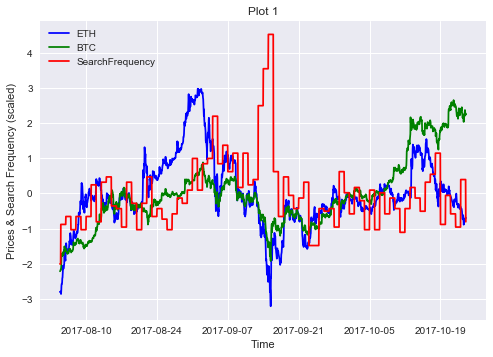

In [5]:
# Plot 1- scaled overlay plot of ETC/BTC prices and GoogleNews search frequency data
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.plot(story_combined_scaled.index, story_combined_scaled['ETH'], color='blue')
plt.plot(story_combined_scaled.index, story_combined_scaled['BTC'], color='green')
plt.plot(story_combined_scaled.index, story_combined_scaled['SearchFrequency'], color='red')
#plt.xlim(('2017-07-26', '2017-10-10'))
plt.legend(loc='upper left')
plt.xlabel('Time')
plt.ylabel('Prices & Search Frequency (scaled)')
plt.title('Plot 1')
plt.show()

From **Plot 1**, I've obsereved the following:
1. Sharp rises in search frequency are coupled with price drops
2. BTC and ETH prices tend to converge during drops, and not spikes (notice that the series were scaled) 

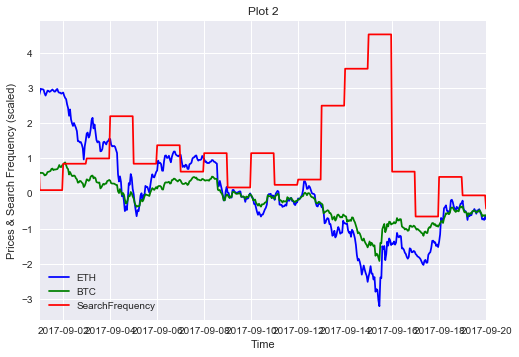

In [6]:
# Plot 2- scaled overlay plot of ETC/BTC prices and GoogleNews search frequency data in 20 days timespand (during drop)

plt.plot(story_combined_scaled.index, story_combined_scaled['ETH'], color='blue')
plt.plot(story_combined_scaled.index, story_combined_scaled['BTC'], color='green')
plt.plot(story_combined_scaled.index, story_combined_scaled['SearchFrequency'], color='red')
plt.xlim(('2017-09-01', '2017-09-20'))
plt.legend(loc='lower left')
plt.xlabel('Time')
plt.ylabel('Prices & Search Frequency (scaled)')
plt.title('Plot 2')
plt.show()

According to **Plot 2**, it looks like sharp rise in search frequency leads ETH/BTC price drop. However, this conclusion is based on just 2 events

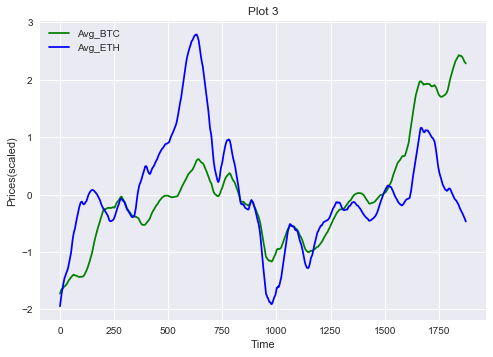

In [7]:
# Plot 3- BTC/ETH moving averages (scaled)
import numpy as np
a = 50
b = a-1
def moving_average(a, n):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

ma_combined = pd.DataFrame()
ma_combined['ETH'] = moving_average(story_combined_scaled['ETH'].values, a)
ma_combined['BTC'] = moving_average(story_combined_scaled['BTC'].values, a)

plt.plot(ma_combined.index, ma_combined['BTC'], color='green', label = 'Avg_BTC')
plt.plot(ma_combined.index, ma_combined['ETH'], color='blue', label = 'Avg_ETH')
plt.legend(loc='upper left')
plt.ylabel('Prices(scaled)')
plt.xlabel('Time')
plt.title('Plot 3')
plt.show()


Based on **Plot 3** , there seem to be correlation between ETH and BTC prices and that ETH leads BTC. However, Granger Causality Test will be performed to confirm the relationship. There's no obvious trend (varying mean over time) or seasonality (varying variance over time) observed at this range. However, Dickey-Fuller test will be perfrom to confirm stationality of the series. 

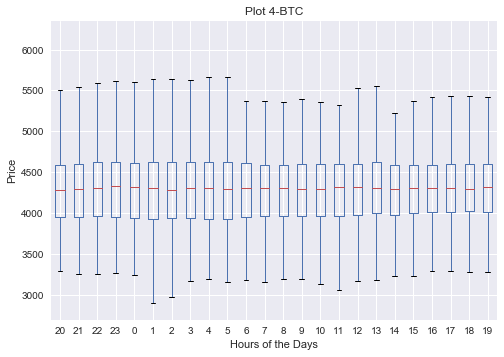

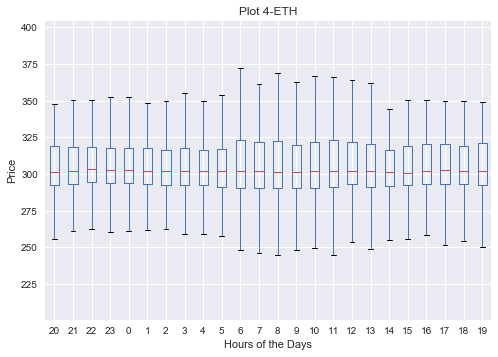

In [8]:
# Plot 4- Box plot by hour of the day
from datetime import datetime, timezone
from collections import OrderedDict
from collections import defaultdict

for coin in story_coin:
    group = OrderedDict.fromkeys(story_combined[coin].index.hour)
    group = defaultdict(list)
    for i in story_combined[coin].index:
        group[i.hour].append(story_combined[coin][i])
    lenght = []
    for key in group:
        lenght.append(len(group[key]))
    min_len = min(lenght)
    hour = pd.DataFrame()
    for key, value in group.items():
        hour[key] = value[:min_len]
    hour.boxplot()
    plt.ylabel('Price')
    plt.xlabel('Hours of the Days')
    plt.title('Plot 4-{}'.format(coin), loc='center')
    plt.show()

**plot 4** shows relatively constant mean, but varying variance throughout hours of the day. However, there's no common patterns observed between BTC and ETH prices stats, which leads me to belive seasonality doesn't exist in these series. 

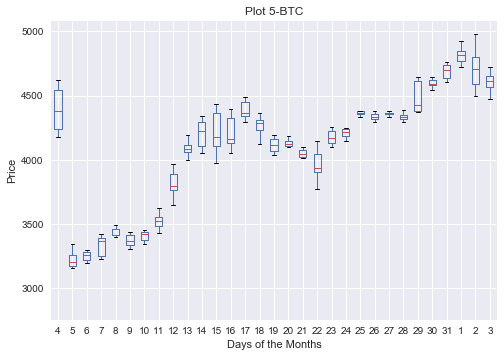

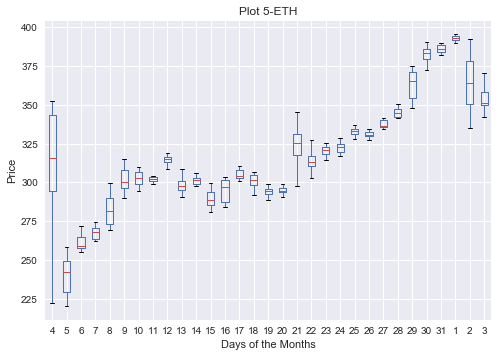

In [26]:
# Plot 5- Box plot by day of the month
for coin in story_coin:    
    group = OrderedDict.fromkeys(story_combined[coin].index.day)
    group = defaultdict(list)
    for i in story_combined[coin].index:
        group[i.day].append(story_combined[coin][i])
    lenght = []
    for key in group:
        lenght.append(len(group[key]))
    min_len = min(lenght)
    day = pd.DataFrame()
    for key, value in group.items():
        day[key] = value[:min_len]
    

    day.boxplot()
    plt.ylabel('Price')
    plt.xlabel('Days of the Months')
    plt.title('Plot 5-{}'.format(coin), loc='center')
    plt.show()


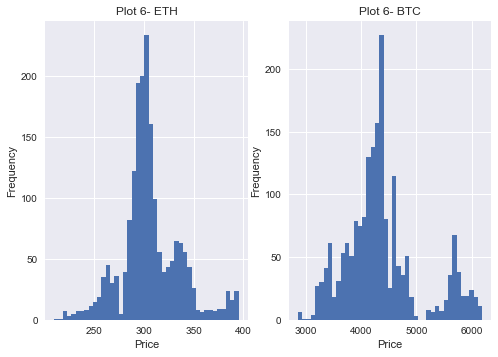

In [10]:
# Plot 6- BTC/ETH histogram
n_data = len(story_combined['ETH'])
n_bins = int(np.sqrt(n_data))
plt.subplot(1, 2, 1)
story_combined['ETH'].hist(bins=n_bins)
plt.ylabel('Frequency')
plt.xlabel('Price')
plt.title('Plot 6- ETH', loc='center')
plt.subplot(1, 2, 2)
story_combined['BTC'].hist(bins=n_bins)
plt.ylabel('Frequency')
plt.xlabel('Price')
plt.title('Plot 6- BTC', loc='center')
plt.show()

**Plot 4** shows that ETH has a sharp frequency peak at ~300, while BTC doesn't have such sharp peak. Depending on personal judgement, if the ETH peak was more extream, it might have been helpful to bias the ETH model to 300. Moreover, BTC histrogram is slightly skewed left, which may have implied BTC market is less "stable". We will further explore histograms of both series after differncing to better quantify "stability". 

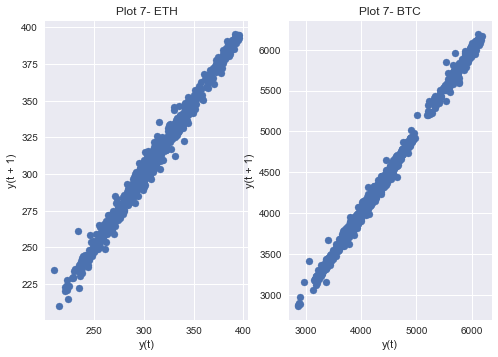

In [11]:
# Plot 7- BTC/ETH lag1 scatter plot
from pandas.plotting import lag_plot
plt.subplot(1, 2, 1)
lag_plot(story_combined['ETH'])
plt.title('Plot 7- ETH', loc='center')
plt.subplot(1, 2, 2)
lag_plot(story_combined['BTC'])
plt.title('Plot 7- BTC', loc='center')
plt.show()

**Plot 5** suggests positive correlation between observations and their consecutive observations (y_t and y_t-1) in both BTC and ETH. To further explore the series, we're going to look at Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots which measure the linear predictability of the series at time t, say x_t, using the value x_s, where s and t denote two valuation points in time. Before we explore ACF and PACF plots, we need to stationarize the series.


In [22]:
# Result 1- Perform Dickey Fuller Test to determine stationality of BTC and ETC time series
from statsmodels.tsa.stattools import adfuller
x = story_combined['ETH'].values
DF_ETH = adfuller(x)
print('\n')
print('Result 1')
print('\n')
print('ADF Statistic (ETH): %f' % DF_ETH[0])
print('p-value: %f' % DF_ETH[1])
print('Critical Values:')
for key, value in DF_ETH[4].items():
    print('\t%s: %.3f' % (key, value))

y = story_combined['BTC'].values
DF_BTC = adfuller(y)
print('\n')
print('ADF Statistic (BTC): %f' % DF_BTC[0])
print('p-value: %f' % DF_BTC[1])
print('Critical Values:')
for key, value in DF_BTC[4].items():
    print('\t%s: %.3f' % (key, value))
print('\n')



Result 1


ADF Statistic (ETH): -3.083591
p-value: 0.027792
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


ADF Statistic (BTC): -1.297649
p-value: 0.630247
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568




From **Result 1** above, Dickey-Fuller test shows that ETH is a stationary series (~95% confidence level), while BTC is NOT a stationary series. To stationarize the series, we're going to perform differencing. There are combinations of lag difference and difference order we could pick from. First, we're going to take the difference using lag 1 order 1 on both series.

In [13]:
# Perfrom differencing to stationalize the series

# create a differenced series, with default value of lag 1
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return diff

# difference the dataset
diff_BTC = difference(story_combined['BTC'])
diff_ETH = difference(story_combined['ETH'])

diff_2 = difference(story_combined['ETH'], 2)
diff_24 = difference(story_combined['ETH'], 24)

# invert differenced forecast #
#def inverse_difference(last_ob, value):
#    return value + last_ob
# invert the difference #
#inverted = [inverse_difference(data[i], diff[i]) for i in range(len(diff))]
#print(inverted)

In [14]:
#diff_BTC = np.diff(story_combined['BTC'], 2)
#diff_ETH = np.diff(story_combined['ETH'], 2)

In [15]:
# Result 2- Perfrom Dickey-Fuller Test on the differenced series
DF_diff_BTC = adfuller(diff_BTC)
print('\n')
print('Result 2')
print('\n')
print('ADF Statistic (BTC): %f' % DF_diff_BTC[0])
print('p-value: %f' % DF_diff_BTC[1])
print('Critical Values:')
for key, value in DF_diff_BTC[4].items():
    print('\t%s: %.3f' % (key, value))
    
    
DF_diff_ETH = adfuller(diff_ETH)
print('\n')
print('ADF Statistic (ETH): %f' % DF_diff_ETH[0])
print('p-value: %f' % DF_diff_ETH[1])
print('Critical Values:')
for key, value in DF_diff_ETH[4].items():
    print('\t%s: %.3f' % (key, value))
print('\n')



Result 2


ADF Statistic (BTC): -40.312685
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


ADF Statistic (ETH): -13.598337
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568




Based on **Result 2**, differencing using lag 1 order 1 improved the stationarity. Both BTC and ETH are now stationary series.

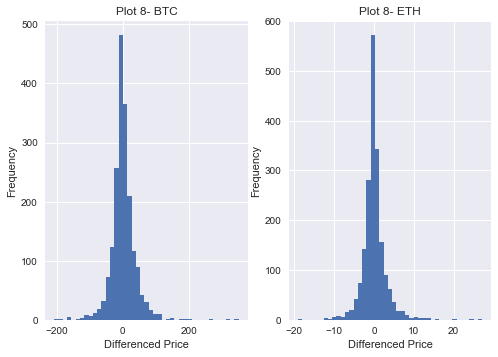

In [16]:
# Plot8- Plotting Histogram of differenced series
n_data = len(diff_ETH)
n_bins = int(np.sqrt(n_data))
plt.subplot(1, 2, 1)
plt.hist(diff_BTC, bins=n_bins)
plt.ylabel('Frequency')
plt.xlabel('Differenced Price')
plt.title('Plot 8- BTC', loc='center')
plt.subplot(1, 2, 2)
plt.hist(diff_ETH, bins=n_bins)
plt.ylabel('Frequency')
plt.xlabel('Differenced Price')
plt.title('Plot 8- ETH', loc='center')
plt.show()


Histogram of the difference, **Plot 6**, shows that the distribution is skewed left. This distribution implies that rising is more rapid than falling. Threshold based on standard deviation of this plot could be used to define "stability" of the series.  

In [61]:
# Result 3- Perfrom Granger Causality Test with the null hypothesis of ETH doesn't Granger cause BTC
import statsmodels.tsa.stattools as sm
diff_BTC_ETH = pd.DataFrame()
diff_BTC_ETH['BTC'] = diff_BTC
diff_BTC_ETH['ETH'] = diff_ETH
print('Result 3')
cor = sm.grangercausalitytests(diff_BTC_ETH, 50)

Result 3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0036  , p=0.9522  , df_denom=1920, df_num=1
ssr based chi2 test:   chi2=0.0036  , p=0.9522  , df=1
likelihood ratio test: chi2=0.0036  , p=0.9522  , df=1
parameter F test:         F=0.0036  , p=0.9522  , df_denom=1920, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3786  , p=0.6849  , df_denom=1917, df_num=2
ssr based chi2 test:   chi2=0.7591  , p=0.6842  , df=2
likelihood ratio test: chi2=0.7590  , p=0.6842  , df=2
parameter F test:         F=0.3786  , p=0.6849  , df_denom=1917, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3441  , p=0.7934  , df_denom=1914, df_num=3
ssr based chi2 test:   chi2=1.0361  , p=0.7925  , df=3
likelihood ratio test: chi2=1.0359  , p=0.7926  , df=3
parameter F test:         F=0.3441  , p=0.7934  , df_denom=1914, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.550

ssr based F test:         F=0.9084  , p=0.6039  , df_denom=1839, df_num=28
ssr based chi2 test:   chi2=26.2227 , p=0.5608  , df=28
likelihood ratio test: chi2=26.0430 , p=0.5707  , df=28
parameter F test:         F=0.9084  , p=0.6039  , df_denom=1839, df_num=28

Granger Causality
number of lags (no zero) 29
ssr based F test:         F=0.9534  , p=0.5371  , df_denom=1836, df_num=29
ssr based chi2 test:   chi2=28.5362 , p=0.4894  , df=29
likelihood ratio test: chi2=28.3234 , p=0.5007  , df=29
parameter F test:         F=0.9534  , p=0.5371  , df_denom=1836, df_num=29

Granger Causality
number of lags (no zero) 30
ssr based F test:         F=0.9104  , p=0.6065  , df_denom=1833, df_num=30
ssr based chi2 test:   chi2=28.2219 , p=0.5587  , df=30
likelihood ratio test: chi2=28.0137 , p=0.5697  , df=30
parameter F test:         F=0.9104  , p=0.6065  , df_denom=1833, df_num=30

Granger Causality
number of lags (no zero) 31
ssr based F test:         F=0.9324  , p=0.5742  , df_denom=1830, df_num=3

In [60]:
# Result 4- Perform Granger Causality Test with the null hypothesis of BTC doesn't Granger cause ETH
diff_ETH_BTC = pd.DataFrame()
diff_ETH_BTC['ETH'] = diff_ETH
diff_ETH_BTC['BTC'] = diff_BTC
print('Result 4')
cor = sm.grangercausalitytests(diff_ETH_BTC, 50)

Result 4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.9868  , p=0.0841  , df_denom=1920, df_num=1
ssr based chi2 test:   chi2=2.9915  , p=0.0837  , df=1
likelihood ratio test: chi2=2.9891  , p=0.0838  , df=1
parameter F test:         F=2.9868  , p=0.0841  , df_denom=1920, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.7304  , p=0.1775  , df_denom=1917, df_num=2
ssr based chi2 test:   chi2=3.4698  , p=0.1764  , df=2
likelihood ratio test: chi2=3.4667  , p=0.1767  , df=2
parameter F test:         F=1.7304  , p=0.1775  , df_denom=1917, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.2205  , p=0.3007  , df_denom=1914, df_num=3
ssr based chi2 test:   chi2=3.6748  , p=0.2988  , df=3
likelihood ratio test: chi2=3.6713  , p=0.2992  , df=3
parameter F test:         F=1.2205  , p=0.3007  , df_denom=1914, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=5.063

ssr based F test:         F=1.3498  , p=0.0950  , df_denom=1830, df_num=31
ssr based chi2 test:   chi2=43.2846 , p=0.0703  , df=31
likelihood ratio test: chi2=42.7971 , p=0.0772  , df=31
parameter F test:         F=1.3498  , p=0.0950  , df_denom=1830, df_num=31

Granger Causality
number of lags (no zero) 32
ssr based F test:         F=1.3144  , p=0.1126  , df_denom=1827, df_num=32
ssr based chi2 test:   chi2=43.5564 , p=0.0836  , df=32
likelihood ratio test: chi2=43.0626 , p=0.0916  , df=32
parameter F test:         F=1.3144  , p=0.1126  , df_denom=1827, df_num=32

Granger Causality
number of lags (no zero) 33
ssr based F test:         F=1.2949  , p=0.1223  , df_denom=1824, df_num=33
ssr based chi2 test:   chi2=44.3022 , p=0.0904  , df=33
likelihood ratio test: chi2=43.7912 , p=0.0992  , df=33
parameter F test:         F=1.2949  , p=0.1223  , df_denom=1824, df_num=33

Granger Causality
number of lags (no zero) 34
ssr based F test:         F=1.3129  , p=0.1076  , df_denom=1821, df_num=3

Based on **Result 3-4**, it's most likely that BTC causes ETH. From ~lag 4 to ~lag 16 (4-16 hours), we observed >99% confidence level. On the other hand, Granger Test failed to prove that ETH causes BTC(failed to reject the null hypothesis). However, the p values improve beyond ~lag 50 (~2days), with confidence level of ~90%.

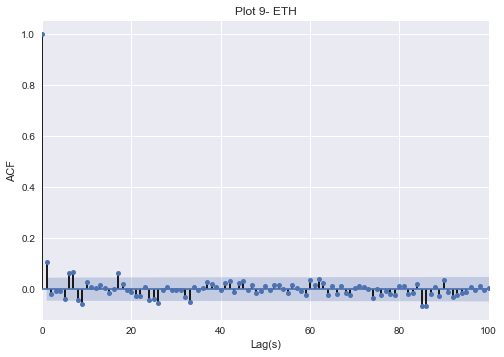

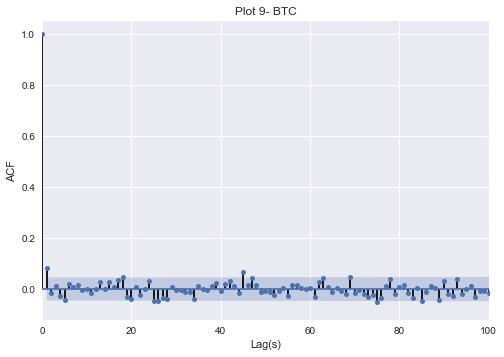

In [30]:
# Plot 9- ACF plot of the differenced series using lag 1 order 1
from statsmodels.graphics.tsaplots import plot_acf
from pandas import tseries
plot_acf(diff_ETH)
plt.title('Plot 9- ETH', loc='center')
plt.xlim((0, 100))
plt.ylabel('ACF')
plt.xlabel('Lag(s)')
plot_acf(diff_BTC)
plt.title('Plot 9- BTC', loc='center')
plt.xlim((0, 100))
plt.ylabel('ACF')
plt.xlabel('Lag(s)')
plt.show()


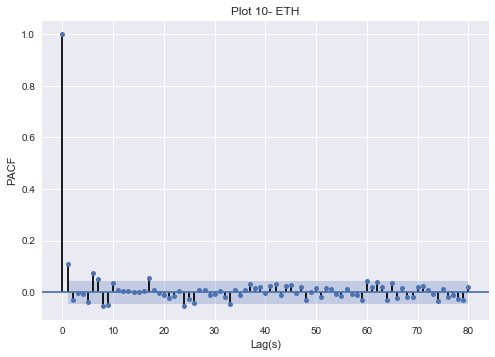

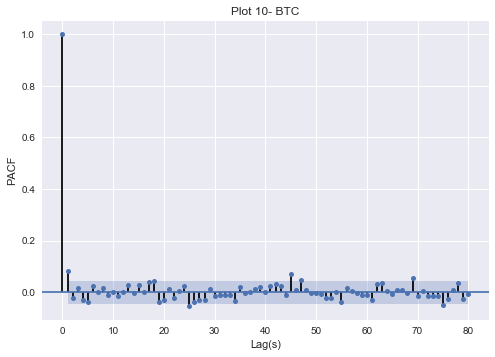

In [29]:
# Plot 10- PACF plot of the differenced series using lag 1 order 1
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(diff_ETH, lags=80)
plt.title('Plot 10- ETH', loc='center')
plt.ylabel('PACF')
plt.xlabel('Lag(s)')

plot_pacf(diff_BTC, lags=80)
plt.title('Plot 10- BTC', loc='center')
plt.ylabel('PACF')
plt.xlabel('Lag(s)')
plt.show()

Since there combinations of lag difference and difference order we could pick from, the following sections explore the combinations.



ADF Statistic: -8.774223
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


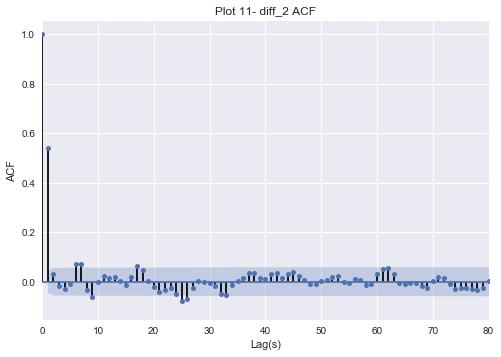

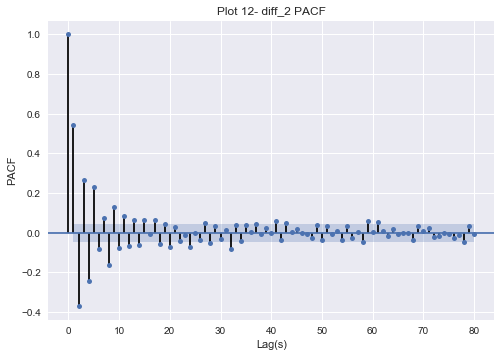

In [31]:
# Dickey Fuller Test result, ACF, and PACF plots of differenced series using lag 2 order 1
DF_diff_2 = adfuller(diff_2)
print('\n')
print('ADF Statistic: %f' % DF_diff_2[0])
print('p-value: %f' % DF_diff_2[1])
print('Critical Values:')
for key, value in DF_diff_2[4].items():
    print('\t%s: %.3f' % (key, value))
    
plot_acf(diff_2)
plt.title('Plot 11- diff_2 ACF', loc='center')
plt.ylabel('ACF')
plt.xlabel('Lag(s)')
plt.xlim([0, 80])
plt.show()

plot_pacf(diff_2, lags=80)
plt.title('Plot 12- diff_2 PACF', loc='center')
plt.ylabel('PACF')
plt.xlabel('Lag(s)')    
plt.show()




ADF Statistic: -5.566813
p-value: 0.000001
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


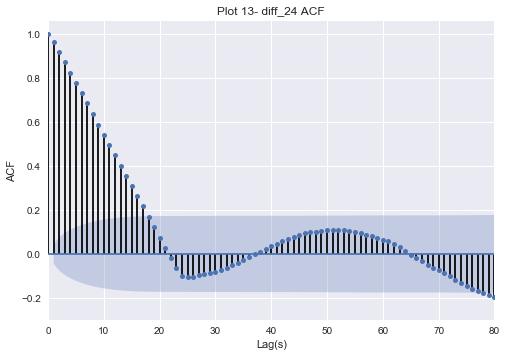

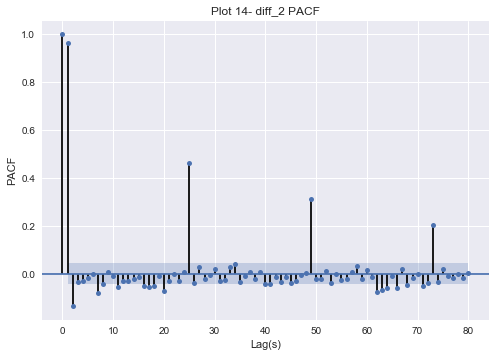

In [32]:
# Dickey Fuller Test result, ACF, and PACF plots of differenced series using lag 2 order 1
DF_diff_24 = adfuller(diff_24)
print('\n')
print('ADF Statistic: %f' % DF_diff_24[0])
print('p-value: %f' % DF_diff_24[1])
print('Critical Values:')
for key, value in DF_diff_24[4].items():
    print('\t%s: %.3f' % (key, value))
    
plot_acf(diff_24)
plt.title('Plot 13- diff_24 ACF', loc='center')
plt.ylabel('ACF')
plt.xlabel('Lag(s)')
plt.xlim([0, 80])
plt.show()

plot_pacf(diff_24, lags=80)
plt.title('Plot 14- diff_2 PACF', loc='center')
plt.ylabel('PACF')
plt.xlabel('Lag(s)')    
plt.show()

### Conclusion:
-  There seem to be high correlation between the rise in search frequency and the drop in currencies prices 
-  High correlation between BTC and ETH ( >99% confidence level )
-  There is a correlation between an observation and it's lag 1 (x_t and x_t-1)
-  Both series have no obvious trends or seasonalities
-  Price rise is more "rapid" than fall
<br><br>
From the conclusion above, my hypothesis is that classical time series analysis ( historical prices alone- i.e. ARIMA model ) might be insufficent when predicting such volatile markets. Using Machine Learning with variety of features such GoogleNews search frequency, relationship with other correlated coins, ther social media APIs and ARIMA model will improve prediction performance significantly. 

Next steps are:
1. Search for more social media APIs for potential features
2. Identify cointegrated crytocurrency pairs (based on Granger Test) and model the relationship between the pairs
3. Analyze price history using ARIMA
4. Based on 1,2,3 come up with a Machine Learning model that best predict future prices
5. Compare the Machine Learning model performance with ARIMA performance

In [21]:
#ar1 